In [8]:
import scipy.sparse
import scipy.linalg
import numpy as np
import mkprop
import matplotlib.pyplot as plt
nrm = lambda x : np.linalg.norm(x,2)

n = 3000
e = np.ones(n)
e1 = np.ones(n-1)
# M is scaled finite difference discretization of 1d Laplace operator
M = scipy.sparse.diags([e1,-2*e,e1], [-1,0,1]) # eigenvalues in [0,4]

# initial vector
u=np.random.rand(n)
u=u/nrm(u)

inr = lambda x,y : np.vdot(x,y)
nrm = lambda x : np.linalg.norm(x)
dt = 50
tol = 1e-6
yref = scipy.sparse.linalg.expm_multiply(1j*dt*M,u)

y,info = mkprop.expimv_pKry(M,u,t=dt,tol=tol,optinfo=1)
print("Test 1, adaptive Krylov propagator. Automatically choose susteps if required.")
print("final t = ",dt)
useddt = info[2]
print("used substeps = ",useddt)
print("approximation error = %.2e, tolerance = %.2e" % (nrm(yref-y)/dt, tol))

fixedts = np.linspace(dt/4,dt,4)
y,info = mkprop.expimv_pKry(M,u,t=dt, m=40,optinfo=1, fixedts=fixedts)

print("\nTest 2, use pre-assigned intermediate times")
print("final t = ",fixedts[-1])
print("pre-assigned intermediate times = ",fixedts)
print("fixed m and substeps, approximation error = %.2e" % (nrm(yref-y)/dt))


Test 1, adaptive Krylov propagator. Automatically choose susteps if required.
final t =  50
used substeps =  [11.975001429609517, 11.975001435432981, 11.975001441256657, 11.975001447080546, 2.099994246620298]
approximation error = 3.82e-08, tolerance = 1.00e-06

Test 2, use pre-assigned intermediate times
final t =  50.0
pre-assigned intermediate times =  [12.5 25.  37.5 50. ]
fixed m and substeps, approximation error = 1.08e-07


In [11]:
nt=20
dtref = 5
dts = np.geomspace(0.2,1,nt)*dtref

YKry, info = mkprop.expimv_pKry(M,u,t=dts,m=10,fixedts=[dtref],optinfo=2)
errs = np.zeros(nt)
errests = info[1]
errests2 = info[-2]
errests3 = info[-1]

for j in range(nt):
    dtnow = dts[j]
    yref = scipy.sparse.linalg.expm_multiply(1j*dtnow*M,u)
    y1 = YKry[:,j]
    errs[j] = nrm(yref-y1)

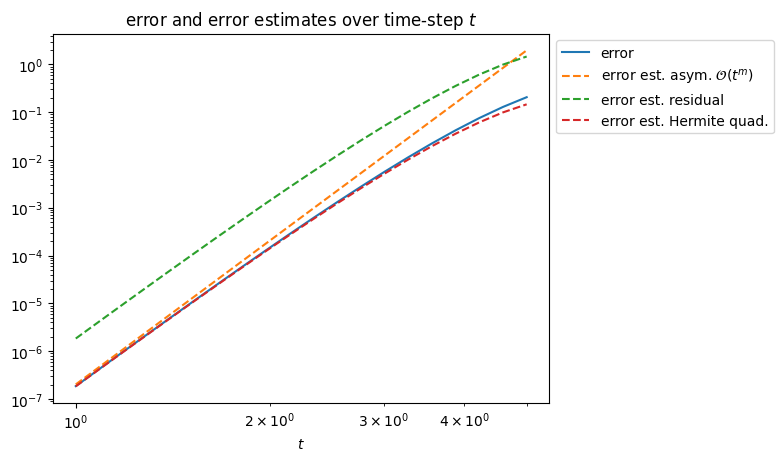

In [12]:

plt.loglog(dts,errs,dts,errests,'--',dts,errests2,'--',dts,errests3,'--');
plt.gca().legend(('error', 'error est. asym. $\mathcal{O}(t^m)$', 'error est. residual', 'error est. Hermite quad.'),
                  bbox_to_anchor=(1.0, 1.0))
plt.title('error and error estimates over time-step $t$')
plt.xlabel('$t$');


In [13]:
dtref = 10
mmax = 50
YKry, info = mkprop.expimv_pKry(M,u,t=dtref,m=mmax,testallm=True,optinfo=2)
errs = np.zeros(mmax)
yref = scipy.sparse.linalg.expm_multiply(1j*dtref*M,u)
errests = info[1]
errests2 = info[-2]
errests3 = info[-1]
for j in range(mmax):
    y1 = YKry[:,j]
    errs[j] = nrm(yref-y1)

Text(0.5, 0, '$m$')

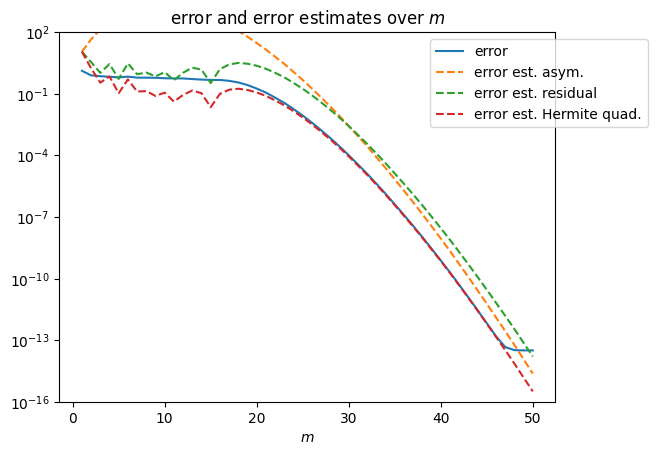

In [14]:
ms = np.arange(1,mmax+1)
plt.semilogy(ms,errs,ms,errests,'--',ms,errests2,'--',ms,errests3,'--')
plt.gca().legend(('error', 'error est. asym.', 'error est. residual', 'error est. Hermite quad.'),
                  bbox_to_anchor=(1.2, 1.0))
plt.title('error and error estimates over $m$')
plt.ylim((1e-16,1e2))
plt.xlabel('$m$')


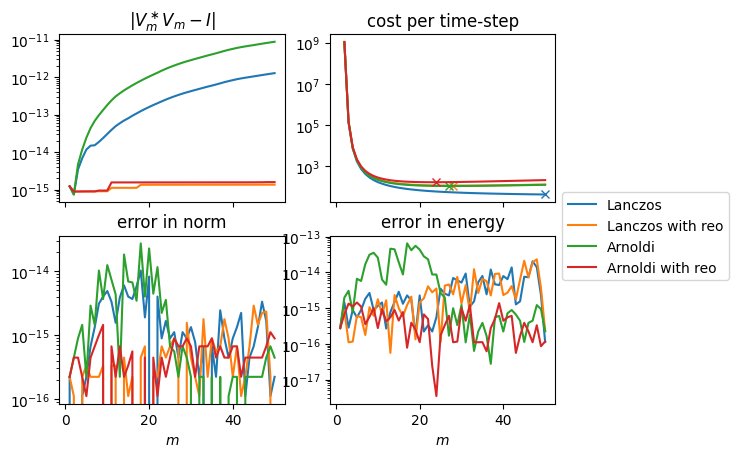

In [15]:
YKry1, info1 = mkprop.expimv_pKry(M,u,t=dtref,m=mmax,testallm=True,optinfo=2,reo=0,ktype=2)
ocheck1 = info1[5]
cstlist1 = info1[6]
bestmlist1 = info1[7]

YKry2, info2 = mkprop.expimv_pKry(M,u,t=dtref,m=mmax,testallm=True,optinfo=2,reo=1,ktype=2)
ocheck2 = info2[5]
cstlist2 = info2[6]
bestmlist2 = info2[7]

YKry3, info3 = mkprop.expimv_pKry(M,u,t=dtref,m=mmax,testallm=True,optinfo=2,reo=0,ktype=1)
ocheck3 = info3[5]
cstlist3 = info3[6]
bestmlist3 = info3[7]

YKry4, info4 = mkprop.expimv_pKry(M,u,t=dtref,m=mmax,testallm=True,optinfo=2,reo=1,ktype=1)
ocheck4 = info4[5]
cstlist4 = info4[6]
bestmlist4 = info4[7]

ms = np.arange(1,mmax+1)

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,sharex=True)
ax3.set_xlabel('$m$')
ax4.set_xlabel('$m$')
ax1.set_title('$\|V_m^\\ast V_m-I\|$')
ax2.set_title('cost per time-step')
ax3.set_title('error in norm')
ax4.set_title('error in energy')

ax1.semilogy(ms,ocheck1,color='tab:blue')
ax1.semilogy(ms,ocheck2,color='tab:orange')
ax1.semilogy(ms,ocheck3,color='tab:green')
ax1.semilogy(ms,ocheck4,color='tab:red')
bm1 = bestmlist1[0]
bm2 = bestmlist2[0]
bm3 = bestmlist3[0]
bm4 = bestmlist4[0]


ax2.semilogy(range(2,mmax+1),cstlist1[0],bm1,cstlist1[0][bm1-2],'x',color='tab:blue')
ax2.semilogy(range(2,mmax+1),cstlist2[0],bm2,cstlist2[0][bm2-2],'x',color='tab:orange')
ax2.semilogy(range(2,mmax+1),cstlist3[0],bm3,cstlist3[0][bm3-2],'x',color='tab:green')
ax2.semilogy(range(2,mmax+1),cstlist4[0],bm4,cstlist4[0][bm4-2],'x',color='tab:red')

nrmu0 = nrm(u)
eu0 = inr(u,M.dot(u))

nrmlist1 = np.zeros(ms.size)
nrmlist2 = np.zeros(ms.size)
nrmlist3 = np.zeros(ms.size)
nrmlist4 = np.zeros(ms.size)
elist1 = np.zeros(ms.size)
elist2 = np.zeros(ms.size)
elist3 = np.zeros(ms.size)
elist4 = np.zeros(ms.size)
for j in range(mmax):
    y1 = YKry1[:,j]
    nrmlist1[j] = abs(nrm(y1)-nrmu0)
    elist1[j] = abs(inr(y1,M.dot(y1))-eu0)
    
    y1 = YKry2[:,j]
    nrmlist2[j] = abs(nrm(y1)-nrmu0)
    elist2[j] = abs(inr(y1,M.dot(y1))-eu0)
    
    y1 = YKry3[:,j]
    nrmlist3[j] = abs(nrm(y1)-nrmu0)
    elist3[j] = abs(inr(y1,M.dot(y1))-eu0)
    
    y1 = YKry4[:,j]
    nrmlist4[j] = abs(nrm(y1)-nrmu0)
    elist4[j] = abs(inr(y1,M.dot(y1))-eu0)
    
ax3.semilogy(ms,nrmlist1,color='tab:blue')
ax3.semilogy(ms,nrmlist2,color='tab:orange')
ax3.semilogy(ms,nrmlist3,color='tab:green')
ax3.semilogy(ms,nrmlist4,color='tab:red')
ax4.semilogy(ms,elist1,color='tab:blue')
ax4.semilogy(ms,elist2,color='tab:orange')
ax4.semilogy(ms,elist3,color='tab:green')
ax4.semilogy(ms,elist4,color='tab:red')

ax4.legend(('Lanczos', 'Lanczos with reo', 'Arnoldi', 'Arnoldi with reo'),
           bbox_to_anchor=(1.0, 1.3));
